In [1]:
import pandas as pd
import warnings
from src.path_utils import sales_fix_path, test_fix_path, shops_fix_path, item_categories_fix_path, items_fix_path, \
    save_final_to, catboost_model_path
from src.modeling.building_features import FeatureModeling
from src.modeling.validation_schema import ValidationSchema
from src.modeling.training_schema import TrainingModel
from src.modeling.utils import create_kaggle_data, downcast
from src.analytics.explainability import Explainability
from src.analytics.feature_importance import FeatureImportance
from src.analytics.error_analysis import ModelErrorAnalysis

import catboost as cb

warnings.filterwarnings("ignore")

In [ ]:
in_features = ['date_block_num', 'shop_id', 'item_id']
target = ['item_cnt_month']
cat_cols = ['date_block_num', 'shop_id', 'item_id']

In [ ]:
fe_simple = FeatureModeling(sales_path=sales_fix_path, shop_path=shops_fix_path, item_path=items_fix_path,
                            item_categories_path=item_categories_fix_path, test_path=test_fix_path)

In [ ]:
fe_simple.create_final_data(make_big=False)

In [ ]:
fe_simple.load_data("final_data")

In [ ]:
vs = ValidationSchema(data=final_data_path)

In [ ]:
validation_dict = vs.train_test_spliter(train_size=32)

In [ ]:
model = TrainingModel(data=fe_simple.get_data(), validation_dict=validation_dict)

In [ ]:
preds = model.train_model(in_features=in_features, target=target, cat_features=cat_cols)

In [ ]:
create_kaggle_data(predictions=preds, file_name="kaggle", save_path=save_final_to)



**Without any Feature Extraction methods and option to include all possible combination date_block_num, shop_id, and item_id if make_big, public kaggle score is 1.52 (what a fuck amigo)**


<img src="../data/images/kaggle_score_1.png">


In [ ]:
fe_with_comb = FeatureModeling(sales_path=sales_fix_path, shop_path=shops_fix_path, item_path=items_fix_path,
                               item_categories_path=item_categories_fix_path, test_path=test_fix_path)

In [ ]:
fe_with_comb.create_final_data(make_big=True)

In [ ]:
fe_with_comb.load_data('final_data')

In [ ]:
vs = ValidationSchema(final_data_path)

In [ ]:
validation_dict = vs.train_test_spliter(train_size=32)

In [ ]:
model = TrainingModel(fe_with_comb.get_data(), validation_dict=validation_dict)

In [ ]:
preds = model.train_model(in_features=in_features, target=target, cat_features=cat_cols)

In [ ]:
create_kaggle_data(predictions=preds, file_name="kaggle", save_path=save_final_to)


**Without Feature Extraction methods but using option to include all possible combination date_block_num, shop_id, and item_id if make_big, public kaggle score is 1.16**


<img src="../data/images/kaggle_score_2.png">


In [ ]:
fe = FeatureModeling(sales_path=sales_fix_path, shop_path=shops_fix_path, item_path=items_fix_path,
                     item_categories_path=item_categories_fix_path, test_path=test_fix_path)

In [ ]:
fe.create_final_data(make_big=True)

In [ ]:
vs = ValidationSchema(fe.get_data())

In [ ]:
validation_dict = vs.train_test_spliter()

In [ ]:
validation_dict

In [ ]:
feature_functions = [
    fe.add_mean_price,
    fe.add_city_features,
    fe.add_item_features,
    fe.add_item_categories_features,
    lambda: fe.add_mean_features(idx_features=['date_block_num', 'item_id']),
    lambda: fe.add_mean_features(idx_features=['date_block_num', 'item_id', 'city']),
    lambda: fe.add_lag_features(idx_features=['date_block_num', 'shop_id', 'item_id'], lag_feature='item_cnt_month',
                                validation_dict=validation_dict, nlags=3),
    lambda: fe.add_lag_features(idx_features=['date_block_num', 'shop_id', 'item_id'], lag_feature='item_mean_price',
                                validation_dict=validation_dict, nlags=3),
    lambda: fe.add_lag_mean_features(idx_features=['date_block_num', 'shop_id', 'item_id'],
                                     validation_dict=validation_dict, nlags=3, drop_mean_features=True),
    lambda: fe.add_mean_features(idx_features=['date_block_num', 'shop_id', 'item_category_id']),
    lambda: fe.add_lag_mean_features(idx_features=['date_block_num', 'shop_id', 'item_category_id'],
                                     validation_dict=validation_dict, nlags=3, drop_mean_features=True),
    fe.final_process
]

In [ ]:
fe.add_features(feature_functions)

In [ ]:
fe.load_data(file_name='final_full_data')

In [ ]:
df = pd.read_csv('../data/final/final_full_data.csv')

In [ ]:
vs = ValidationSchema(df)

In [ ]:
validation_dict = vs.train_test_spliter()

In [ ]:
# lag features for final full data

lag_features = {0: ['item_cnt_month_lag1_0',
                    'item_cnt_month_lag2_0',
                    'item_cnt_month_lag3_0',
                    'item_mean_price_lag1_0',
                    'item_mean_price_lag2_0',
                    'item_mean_price_lag3_0',
                    'item_id_mean_sales_lag1_0',
                    'item_id_mean_sales_lag2_0',
                    'item_id_mean_sales_lag3_0',
                    'item_id_city_mean_sales_lag1_0',
                    'item_id_city_mean_sales_lag2_0',
                    'item_id_city_mean_sales_lag3_0',
                    'shop_id_item_category_id_mean_sales_lag1_0',
                    'shop_id_item_category_id_mean_sales_lag2_0',
                    'shop_id_item_category_id_mean_sales_lag3_0',
                    'item_cnt_month_lag_mean_0']}

In [ ]:
in_features = ['date_block_num', 'shop_id', 'item_id', 'month',
               'city', 'shop_category', 'item_category_id',
               'duration_after_first_sale', 'category']
target = ['item_cnt_month']
cat_cols = ['date_block_num', 'shop_id', 'item_id', 'month',
            'city', 'shop_category', 'item_category_id',
            'duration_after_first_sale', 'category']

In [ ]:
model = TrainingModel(data=df, validation_dict=validation_dict, params={})

In [ ]:
preds = model.train_model(in_features=in_features, lag_features=lag_features, target=target, cat_features=cat_cols,
                          save_model=True, model_name='catboost_full')

In [ ]:
create_kaggle_data(predictions=preds, file_name='kaggle_with_features_1', save_path=save_final_to)

**With using feature modeling and option to include all possible combination date_block_num, shop_id, and item_id if make_big, public kaggle score is 1.07**


<img src="../data/images/kaggle_score_4.png">

In [2]:
df = pd.read_csv('../data/final/final_subdata.csv')

In [3]:
df = downcast(df)

58.5% compressed


In [4]:
vs = ValidationSchema(df)

In [5]:
validation_dict = vs.train_test_spliter()

In [6]:
model = cb.CatBoostRegressor()

In [7]:
model.load_model('../models/catboost_sub')

In [8]:
val = df[df['date_block_num'].isin([row['val'] for row in validation_dict['validation_indexes']][0])]

In [9]:
expl = Explainability(model=model, val_data=val, validation_dict=validation_dict)


Summary plot:


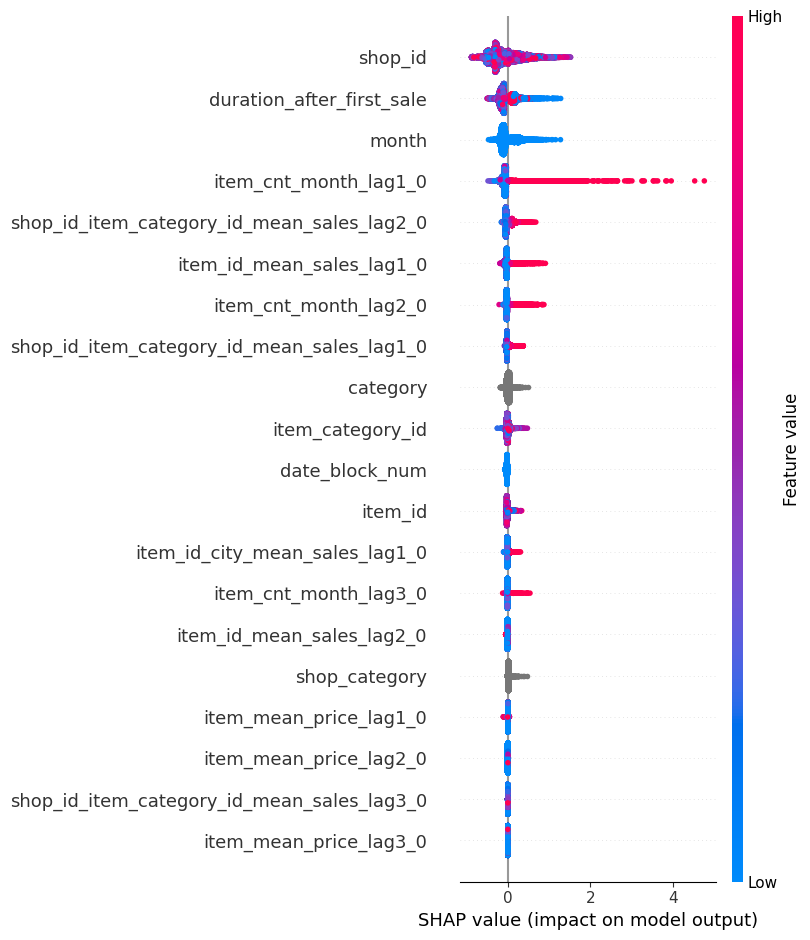

In [10]:
expl.shap_summary()


Dependence plot:


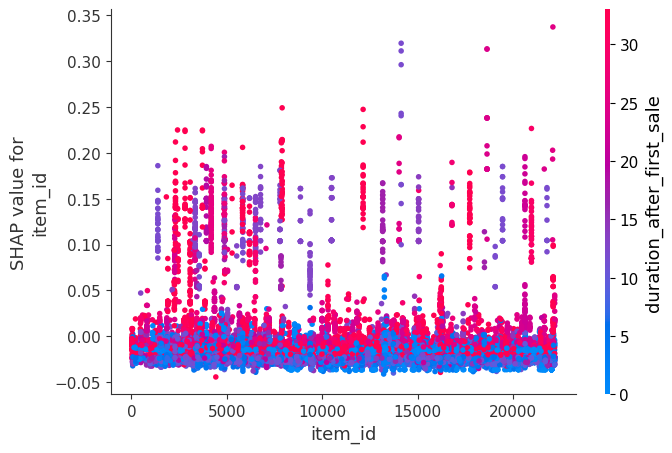

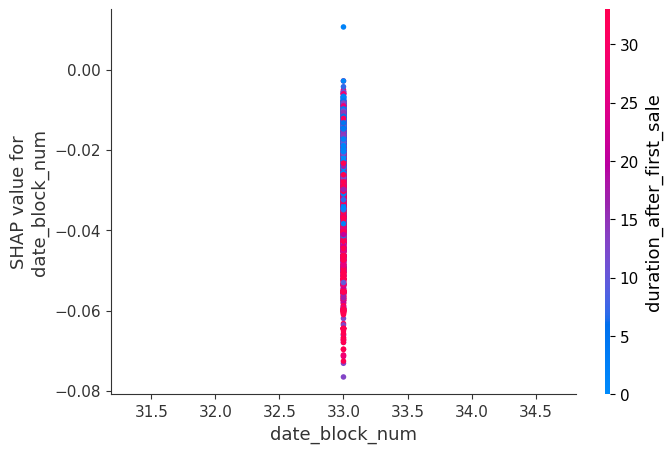

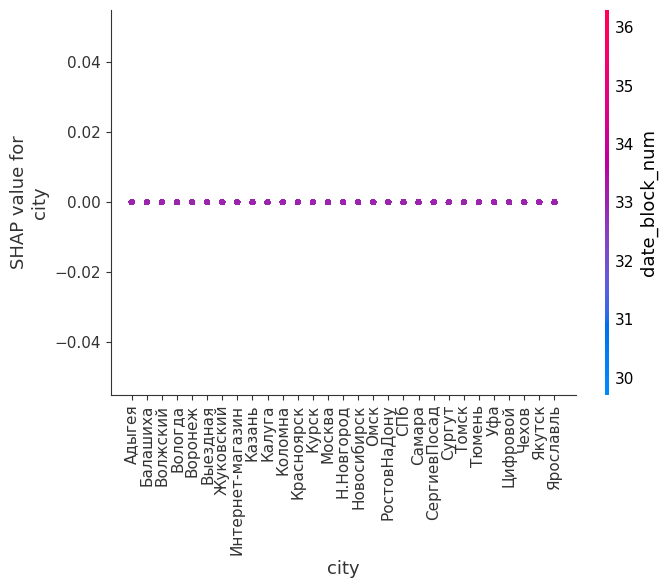

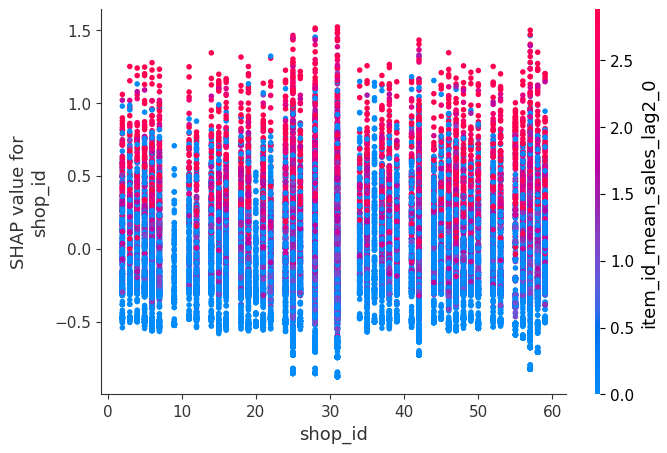

In [12]:
expl.shap_dependece(dep_features_name=["item_id","date_block_num","city","shop_id"])

In [8]:
fi = FeatureImportance(model=model, df=df, validation_dict=validation_dict)

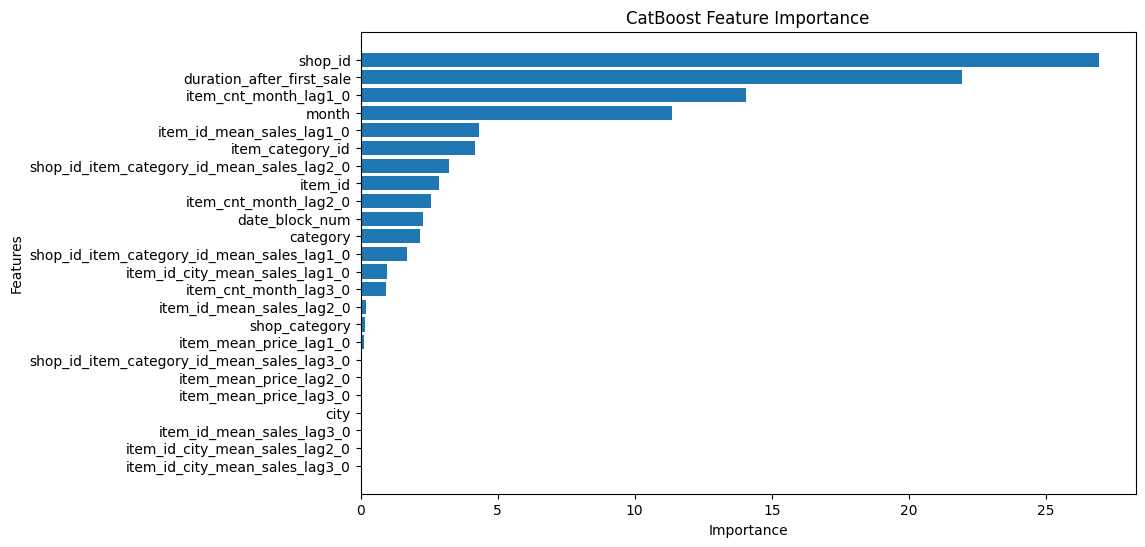

In [9]:
fi.feature_importance_visualize()

In [11]:
merr = ModelErrorAnalysis(model=model, df=df, validation_dict=validation_dict)

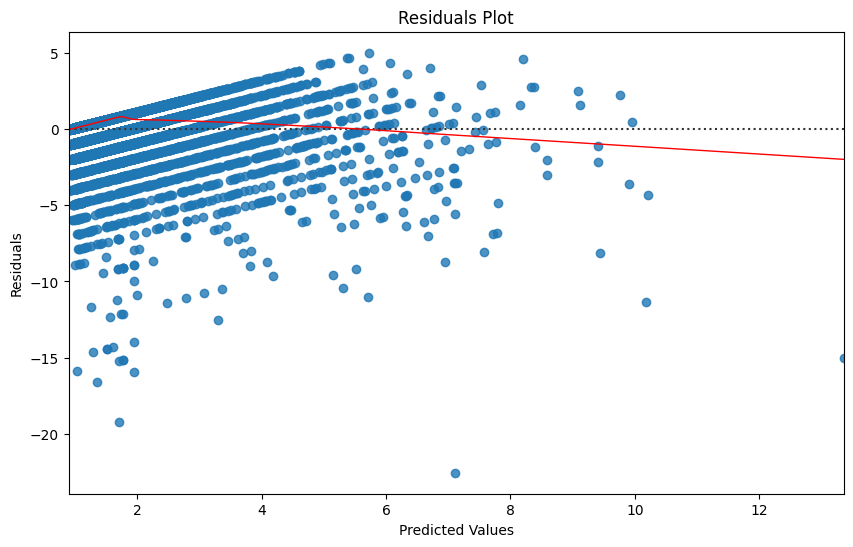

In [16]:
merr.plot_residuals()